## CAFIR

CAFIR significa Cadastro de Imóveis Rurais. Através do site de [dados abertos do Governo Federal](https://dados.gov.br/home) é possível obter vários dados relacionados a tais imóveis, com exceção de informações protegidas pela Lei Geral de Proteção de Dados.

### Scraping

Para obtenção dos [dados](https://dadosabertos.rfb.gov.br/CAFIR/) será utilizado o arquivo na pasta Scripts chamado [scrap_csv.py](Scripts/scrap_csv.py), o qual irá baixar os CSVs referentes a dados Estaduais e os unirá em um único CSV.

### Limpeza de dados

O arquivo CSV resultante tem uma divisão fixa para o tamanho de cada coluna, muitos caracteres em brancos, datas com formato não padronizado e caracteres não-alfanuméricos, então é importante fazer uma "higiene" para facilitar sua inserção em bancos de dados e a visualização de seus dados.
O layout do CSV pode ser consultado também no site de [dados abertos](https://dadosabertos.rfb.gov.br/CAFIR/Layout%20Campos%20Dados%20Abertos%20Cafir.pdf), o qual utilizei como parâmetro para trocar o tamanho fixo de coluna por separadores. 
Para a limpeza dos dados foi utilizado o script [clean_csv.py](Scripts/clean_csv.py).
O resultado foi uma diminuição de quase 50% no tamanho do arquivo, que ajuda a diminuir o tempo para as queries futuras.

### SQL

Para analisar um volume tão grandes de dados é mais eficiente a utilização de um sistema de bancos de dados SQL, nesse caso em específico o Microsoft SQL. A tabela foi criada com base no layout fornecido [aqui](https://dadosabertos.rfb.gov.br/CAFIR/Layout%20Campos%20Dados%20Abertos%20Cafir.pdf). 

### Python
Serão necessárias as seguintes bibliotecas nesse projeto: Numpy, Pandas, Matplotlib, seaborn e pypyodbc. Abaixo está o comando para instalá-los.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pypyodbc as odbc

Para começar, será testada a conexão com o servidor SQL na tabela CSVs_unidos que contém os dados do CAFIR

In [14]:
DRIVER_NAME = 'SQL SERVER'
SERVER_NAME = r'DESKTOP-5V1VIGP\SQLEXPRESS'
DATABASE = 'Projeto CAFIR'
USERNAME = 'dbo'

connection_string = f"""
    DRIVER={{{DRIVER_NAME}}};
    SERVER={SERVER_NAME};
    DATABASE={DATABASE};
    UID={USERNAME};
    Trusted_Connection=yes;
"""

conn = odbc.connect(connection_string)
cursor = conn.cursor()

# Verificação da conexão
cursor.execute("SELECT COUNT(*) FROM CAFIR;")
row = cursor.fetchone()
print(row[0])

9987628


## Análise sobre os dados 

### 1 - 
Buscando uma informação básica, realizei a soma de todos hectares dos imóveis ruras disponíveis no banco de dados.

In [20]:
cursor.execute(
    "SELECT SUM([Área total do imóvel (em hectares)])"
    "FROM [Projeto CAFIR].[dbo].[CSVs_unidos]"
)
soma= int(cursor.fetchone()[0])

print(f'A soma da área total dos imóveis é {soma} hectares')

A soma da área total dos imóveis é 25534799544 hectares


Porém o valor da soma, 25.534.799.544 hectares, é maior do que o território brasileiro, que possui cerca de 833.721.800 Hectares segundo o [IBGE](https://agenciadenoticias.ibge.gov.br/agencia-sala-de-imprensa/2013-agencia-de-noticias/releases/14318-asi-ibge-apresenta-nova-area-territorial-brasileira-8515767049-km). Portanto é seguro assumir que há registros que contam o mesmo território. Para continuar a investigação, será investigado quantas entradas estão duplicadas. O NIRF por definição na minha DB é um número único por entrada, mas para conferir, foi realizada a segunda pesquisa:

In [9]:
cursor.execute(
    "SELECT [NIRF - Número do imóvel na Receita Federal]"
    ", count(*)"
    "FROM [Projeto CAFIR].[dbo].[CSVs_unidos]"
    "GROUP BY [NIRF - Número do imóvel na Receita Federal]"
    "HAVING COUNT(*) > 1"
)
duplicatas = cursor.fetchone()

print(duplicatas)

None


Como esperado, não há duplicatas. Então é necessário por outro parâmetro de identificação, que é o código do imóvel no INCRA. Para não ficar muito extenso, nesse caderno mostrarei só as primeiras 20 linhas de resultados.

In [10]:
cursor.execute(
    "SELECT TOP 20 [codigo_incra], COUNT(*) "
    "FROM [Projeto CAFIR].[dbo].[CAFIR] "
    "GROUP BY [codigo_incra] "
    "HAVING COUNT(*) > 1 "
    "ORDER BY [codigo_incra]"
)

duplicatas_incra = cursor.fetchall()

for row in duplicatas_incra:
    print(f'Número do INCRA:{row[0]} - Quantidade de duplicatas: {row[1]}')

Número do INCRA: - Quantidade de duplicatas: 6337693
Número do INCRA:0000193771980 - Quantidade de duplicatas: 2
Número do INCRA:0000271103450 - Quantidade de duplicatas: 2
Número do INCRA:0000353450166 - Quantidade de duplicatas: 2
Número do INCRA:0000435650082 - Quantidade de duplicatas: 2
Número do INCRA:0000600479709 - Quantidade de duplicatas: 2
Número do INCRA:0000600951092 - Quantidade de duplicatas: 2
Número do INCRA:0000601952513 - Quantidade de duplicatas: 3
Número do INCRA:0010400372220 - Quantidade de duplicatas: 2
Número do INCRA:0010400524691 - Quantidade de duplicatas: 2
Número do INCRA:0011041287910 - Quantidade de duplicatas: 2
Número do INCRA:0011121522502 - Quantidade de duplicatas: 2
Número do INCRA:0011710046346 - Quantidade de duplicatas: 2
Número do INCRA:0240230178179 - Quantidade de duplicatas: 3
Número do INCRA:0450980214821 - Quantidade de duplicatas: 3
Número do INCRA:0480380537836 - Quantidade de duplicatas: 2
Número do INCRA:0480620001165 - Quantidade de d

Como é possível ver, há vários (6.337.711) imóveis sem cadastro no INCRA e pelo menos algumas duplicatas. Isso não deveria ser possível, mas é possível que os dados:
- Foram cadastrados erroneamente
- Não houve padronização na integração entre o sistema do CAFIR e do INCRA
- Há cadastro de propriedades sobrepostas, pois em regiões onde não há regularização fundiária plena, diferentes proprietários podem registrar o mesmo imóvel ou partes sobrepostas.

O Código SNR é representação disso. Os códigos representam:
- 1: Vinculação Provisória Realizada
- 2: Vinculação Confirmada
- 3: Desvinculado
- 4: Descaracterização de destinação Rural

- O imóvel desvinculado do Incra implica em:
    - O imóvel pode estar registrado apenas para fins fiscais (imposto sobre a propriedade rural - ITR), mas nunca foi cadastrado no Sistema Nacional de Cadastro Rural (SNCR) do INCRA. O imóvel não terá um CCIR (Certificado de Cadastro de Imóvel Rural), que é obrigatório para várias operações legais, como compra, venda, hipoteca e regularização fundiária e também terá dificuldade em acessar programas de crédito rural ou outros benefícios que exigem o cadastro no INCRA.
    - Ser uma propriedade em áreas urbanas ou transição rural-urbana: O imóvel pode estar situado em uma área que foi convertida para zona urbana, mas permanece cadastrado no CAFIR para fins tributários. Nesse caso, o imóvel pode não ser mais exigido no SNCR (INCRA).
    - Pequenos imóveis rurais sem obrigatoriedade de cadastro no INCRA: Imóveis com áreas muito pequenas ou propriedades familiares podem não ter sido cadastrados no INCRA, especialmente se o proprietário não solicitou o CCIR. Isso ocorre com frequência em áreas onde o controle fundiário é menos rigoroso. Embora não seja exigido para pequenos imóveis em algumas circunstâncias, a ausência do cadastro no INCRA pode dificultar a regularização ou a transferência do imóvel no futuro.

Corrigindo o código para incluir apenas Vinculação Confirmada, vemos que não há linhas sendo retornadas. Já se procurarmos por Vinculação Provisória Realizada, há 3649953 propriedades. Portanto segundo o CSV não há vinculações confirmadas no CSV.

In [ ]:
cursor.execute(
  "SELECT COUNT([Código SNCR])"
  "FROM [Projeto CAFIR].[dbo].[CSVs_unidos]"
  "WHERE [Código SNCR] = '2'"
)

sncr2 = cursor.fetchall()

if not sncr2:
    print("Nenhum resultado encontrado.")
else:
    print(f"Quantidade de registros com código SNCR igual a 2: {sncr2[0][0]}")

Quantidade de registros com código SNCR igual a 2: 0


In [15]:
cursor.execute(
  "SELECT COUNT([SNCR])"
  "FROM [Projeto CAFIR].[dbo].[CAFIR]"
  "WHERE [SNCR] = '1'"
)

sncr1 = cursor.fetchall()

if not sncr1:
    print("Nenhum resultado encontrado.")
else:
    print(f"Quantidade de registros com código SNCR igual a 1: {sncr1[0][0]}")

Quantidade de registros com código SNCR igual a 1: 3647859


Pode-se então dividir as propriedades em: 
- Propriedes com vinculação provisória (1)
- Propriedades não vinculadas (3)
- Propriedades descaracterizadas de destinação Rural(4)

Para pesquisas sobre propriedades rurais então deve-se excluir linhas com o valor 4 da tabela Código SNCR.

Outra coluna interessante para pesquisas é a tabela de Situação do Imóvel, que pode estar ativo, com pendências cadastrais ou com cancelamentos. Para acesso aos códigos com mais detalhes, o [layout da tabela](https://dadosabertos.rfb.gov.br/CAFIR/Layout%20Campos%20Dados%20Abertos%20Cafir.pdf) é explicado no link. 
Cada um dos códigos de pendências devem ser solucionados pelos órgãos responsáveis por eles a fim de levar uma maior consistência no cadastro dos imóveis rurais, o que levaria a uma maior agilidade em procedimentos de compra e venda, herança, coleta de impostos, etc. 

### Conclusões sobre a tabela de dados do CAFIR
1. Os dados sobre o tamanho dos hectares devem ser usados com cuidado em análises espaciais, pois não há garantia de que não haverá duplicidade de dados sobre o território.
2. Não há imóveis com vinculação confirmada através do código SNCR, ou seja, que haja vinculação confirmada do CAFIR com o INCRA, então deve ser estudada o motivo para só haver imóveis com vinculação provisória.

## Análises gráficas 
Uma classificação que utilizarei é o conceito de **Módulo Fiscal**(MF), que é uma área em hectares definida municipalmente.Para as análises gráficas utilizarei como exemplo o estado do Paraná, porquê [a classificação do tamanho da terra é relativamente uniforme](https://www.embrapa.br/codigo-florestal/area-de-reserva-legal-arl/modulo-fiscal), entre 5 e 20 hectares, em média 12,5 ha. 
- Segundo a [Lei nº 8.629/1993 (Art. 4, II e III)](https://www.planalto.gov.br/ccivil_03/leis/l8629.htm), o tamanho das propriedades, com base nos Módulos Fiscais, é o seguinte:
  - Pequena propriedade: 1 a 4 mf
  - Média propriedade: 4 a 15 mf
  - Implicitamente, microfúndios são menores que 1 mf e latifúndios são maiores que 15 mf

### Propriedades vinculadas e desvinculadas no Paraná

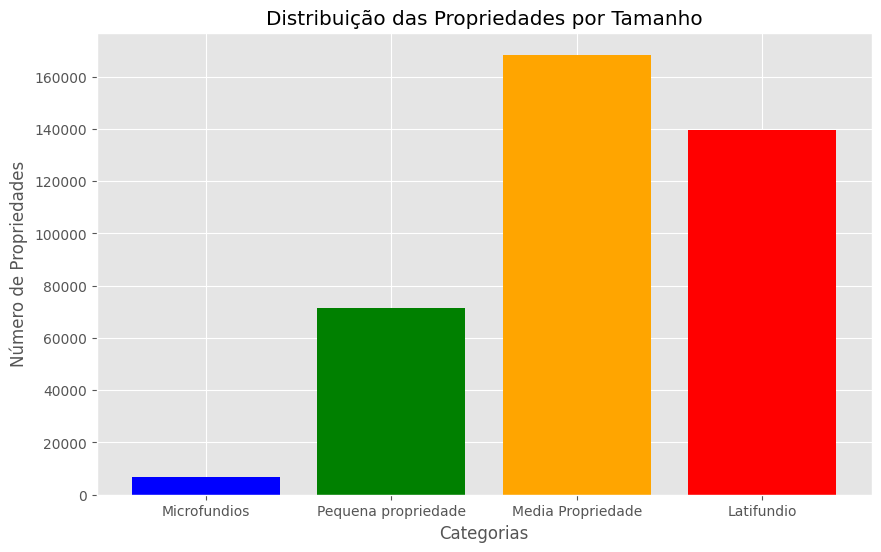

In [18]:

#SNCR será considerado como 1 pois representa a Propriedes com vinculação provisória
cursor.execute(
       """ SELECT [NIRF]
      ,[hectares]
      ,[codigo_incra]
      ,[nome]
      ,[situacao]
      ,[logradouro]
      ,[distrito]
      ,[UF]
      ,[municipio]
      ,[CEP]
      ,[data_att_cadastro]
      ,[imunte_isento]
      ,[SNCR]
        FROM [Projeto CAFIR].[dbo].[CAFIR]
        WHERE [UF] = 'PR' AND [SNCR] = '1'"""
    )

linhas = cursor.fetchall()
colunas = [desc[0] for desc in cursor.description]
df_pr = pd.DataFrame(linhas, columns=colunas)

df_pr['hectares'] = df_pr['hectares'].astype(float)
# Dividindo os valores da coluna 'hectares' por 12.5 e criando a coluna 'modulos_fiscais'
df_pr['modulos_fiscais'] = df_pr['hectares'] / 12.5

labels = ['Microfundios', 'Pequena propriedade', 'Media Propriedade', 'Latifundio']
sizes = [
    len(df_pr[df_pr['modulos_fiscais'] < 1]),
    len(df_pr[(df_pr['modulos_fiscais'] >= 1) & (df_pr['modulos_fiscais'] < 4)]),
    len(df_pr[(df_pr['modulos_fiscais'] >= 4) & (df_pr['modulos_fiscais'] < 15)]),
    len(df_pr[df_pr['modulos_fiscais'] >= 15])
]

plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
plt.bar(labels, sizes, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Categorias')
plt.ylabel('Número de Propriedades')
plt.title('Distribuição das Propriedades por Tamanho')

plt.show()


In [23]:
# Calculando a soma acumulada dos valores
tamanho_cumulativo = [sum(sizes[:i+1]) for i in range(len(sizes))]

plt.style.use('ggplot')

# Criando o gráfico de barras com a soma acumulada
plt.figure(figsize=(10, 6))
plt.bar(labels, tamanho_cumulativo, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Categorias')
plt.ylabel('Tamanho Acumulado das Propriedades em Módulos Fiscais')
plt.title('Distribuição Acumulada das Propriedades por Tamanho')
plt.show()

TypeError: 'int' object is not callable

Como é possível observar, apesar de a maior parte das propriedades serem de médio porte, a maior parte da área total é composta por latifúndios.


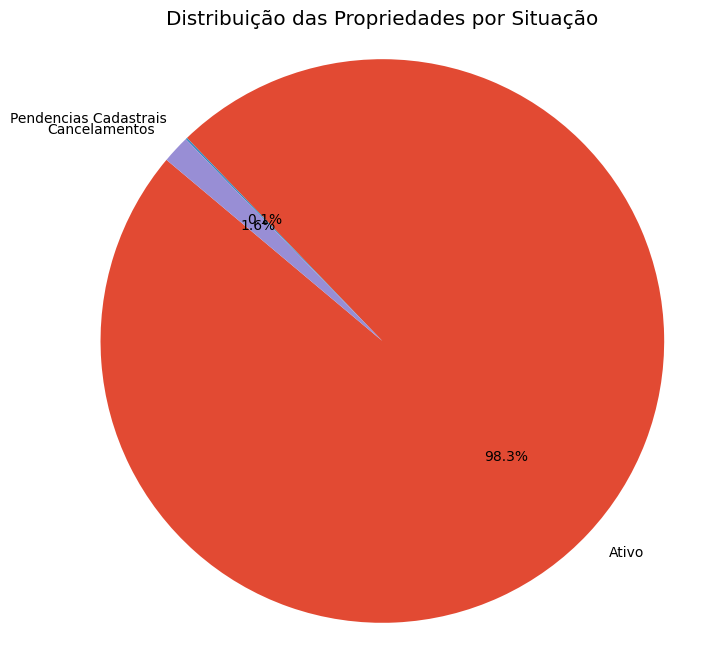

In [5]:
import database_utils as db_utils
import pandas as pd
import matplotlib.pyplot as plt

server_name = r'DESKTOP-5V1VIGP\SQLEXPRESS'
database = 'Projeto CAFIR'
username = 'dbo'

df_pr = db_utils.get_df_pr(server_name, database, username)

# Filtrando os dados com base nos valores da coluna 'situacao'
ativo = df_pr[df_pr['situacao'] == 2]
pendencias_cadastrais = df_pr[df_pr['situacao'].isin([83, 88, 93, 94, 95, 96, 98])]
cancelamentos = df_pr[df_pr['situacao'].isin([46, 47, 48, 49, 50, 51, 52, 55, 56, 57, 58, 59])]

# Contando o número de ocorrências em cada categoria
sizes = [len(ativo), len(pendencias_cadastrais), len(cancelamentos)]
labels = ['Ativo', 'Pendencias Cadastrais', 'Cancelamentos']

# Aplicando o estilo seaborn
plt.style.use('ggplot')

# Criando o gráfico de pizza
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribuição das Propriedades por Situação')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Exibindo o gráfico
plt.show()


E a maioria dentre os imóveis analizados está com o cadastro devidamente ativo.